In [ ]:
 !pip install decile-spear

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 418 kB/s 
     |████████████████████████████████| 11.2 MB 62.5 MB/s 
     |████████████████████████████████| 960 kB 67.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
from spear.labeling import labeling_function, ABSTAIN, preprocessor
import enum
import os 
import uuid
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import json

# Preprocessing Functions

In [ ]:
def segment_patch(filename):
    unique_file = filename[:-4] + str(uuid.uuid4())+".jpg"
    os.system(f'python3 /content/drive/MyDrive/HL/demo.py --input {filename} --output {unique_file} --maxIter 1000 --minLabels 2')
    return unique_file

In [ ]:
def contour_patch(og_patch,segmented_patch):
  img = cv2.imread(segmented_patch, cv2.IMREAD_UNCHANGED)
  img_grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  thresh = 176
  ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)
  contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  boxes = []
  new_dir = "/content/patches"+segmented_patch[:-4][segmented_patch[:-4].rfind("/"):]
  try:
    os.mkdir(new_dir) # -4 cause last 4 characters of extension are removed
  except:
    pass
  og_img = cv2.imread(og_patch, cv2.IMREAD_UNCHANGED)
  for i in range(len(contours)):
    contour = contours[i]
    x,y,w,h = cv2.boundingRect(contour)
    boxes.append([x,y,w,h])
    cropped_img = og_img[y:y+h, x:x+w]
    # cv2_imshow(cropped_img)
    cv2.imwrite(f"{new_dir}/{i}.jpg",cropped_img)
  for box in boxes:
    x,y,w,h = box
    cv2.rectangle(og_img, (x, y), (x + w, y + h), (255,0,0), 4)
    
  cv2.imwrite(f"{new_dir}.jpg",og_img)
  return new_dir,boxes

In [ ]:
def preprocess(filename):
  seg_file = segment_patch(filename)
  new_dir,boxes = contour_patch(filename, seg_file)
  return new_dir,boxes

In [ ]:
preprocess("/content/patch2.jpg")

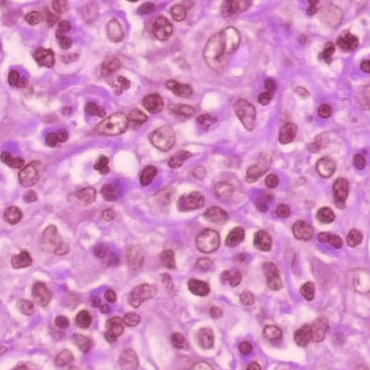

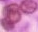

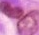

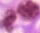

('/content/patches/patch2bbe6ddea-76c4-4e19-a12c-c964c182b184',
 [[0, 0, 370, 370],
  [69, 366, 4, 3],
  [17, 364, 11, 5],
  [194, 363, 3, 3],
  [60, 360, 9, 8],
  [68, 358, 5, 5],
  [55, 356, 5, 6],
  [237, 340, 17, 18],
  [200, 338, 4, 5],
  [79, 338, 14, 17],
  [73, 335, 4, 4],
  [170, 333, 17, 18],
  [202, 332, 12, 17],
  [269, 326, 14, 19],
  [293, 325, 31, 23],
  [263, 325, 9, 9],
  [322, 323, 8, 12],
  [318, 319, 5, 5],
  [54, 316, 16, 21],
  [103, 313, 38, 32],
  [117, 330, 3, 2],
  [127, 321, 1, 1],
  [74, 310, 20, 21],
  [209, 307, 10, 12],
  [134, 306, 5, 4],
  [246, 302, 4, 4],
  [26, 301, 9, 10],
  [245, 295, 3, 4],
  [89, 288, 28, 28],
  [130, 284, 16, 23],
  [300, 282, 16, 21],
  [32, 282, 20, 22],
  [187, 278, 24, 20],
  [162, 274, 10, 8],
  [222, 270, 21, 18],
  [199, 266, 7, 6],
  [263, 262, 18, 29],
  [291, 259, 5, 8],
  [196, 258, 13, 7],
  [138, 258, 6, 9],
  [236, 253, 11, 11],
  [206, 252, 5, 3],
  [209, 250, 6, 4],
  [13, 250, 20, 20],
  [213, 249, 3, 3],
  [160

In [ ]:
contour_patch("/content/patch2.jpg","/content/patch2bbe6ddea-76c4-4e19-a12c-c964c182b184.jpg")

In [ ]:
preprocess("/content/patch2.jpg")

# Labelling Functions

In [ ]:
spacing = 0.25

In [ ]:
# enum to hold the class labels
class ClassLabels(enum.Enum):
    NUC = 1
    CEL = 0
    RSC = 2

In [ ]:
@labeling_function(label=ClassLabels.NUC)
def nucleus(cropped): 
    cpd_img = cv2.imread(cropped)
    h, w, c = cpd_img.shape
    if h*w >10/(spacing**2) and h*w < 40/(spacing**2):
      # print((h*w)*(spacing**2))
      return ClassLabels.NUC
    else:
      return ABSTAIN

In [ ]:
@labeling_function(label=ClassLabels.CEL)
def cell(cropped): 
    cpd_img = cv2.imread(cropped)
    h, w, c = cpd_img.shape
    if h*w >70/(spacing**2):
      return ClassLabels.CEL
    else:
      return ABSTAIN

In [ ]:
@labeling_function(label=ClassLabels.RSC)
def reed_steinberg(cropped): 
    cpd_img = cv2.imread(cropped)
    h, w, c = cpd_img.shape
    if h*w >40/(spacing**2) and h*w < 70/(spacing**2):
      # print((h*w)*(spacing**2))
      # cv2_imshow(cpd_img)
      return ClassLabels.RSC
    else:
      return ABSTAIN

In [ ]:
pname = "/content/patches/patch2bbe6ddea-76c4-4e19-a12c-c964c182b184"
print(len(os.listdir(pname)))
count = 0
for fil in os.listdir(pname):
  x = reed_steinberg(os.path.join(pname, fil))
  if x[0]:
    count+=1

print("Count", count)

150
Count 5


In [ ]:
from spear.labeling import LFSet

LFS = [nucleus, cell, reed_steinberg]

rules = LFSet("HL")
rules.add_lf_list(LFS)

In [ ]:
from spear.labeling import PreLabels
pname = "/content/patches/patch2bbe6ddea-76c4-4e19-a12c-c964c182b184"
nucleus_labels = PreLabels(name="HL",
                               data=np.array([os.path.join(pname, fil) for fil in os.listdir(pname)]),
                               rules=rules,
                              #  gold_labels=np.ones(277),
                               labels_enum=ClassLabels,
                               num_classes=3)

In [ ]:
labels,S = nucleus_labels.get_labels()

100%|██████████| 150/150 [00:00<00:00, 4971.48it/s]


In [ ]:
labels

array([[1, None, None],
       [1, None, None],
       [1, None, None],
       [1, None, None],
       [None, None, None],
       [None, None, None],
       [None, None, None],
       [None, None, None],
       [None, None, None],
       [None, None, None],
       [None, None, None],
       [None, None, None],
       [1, None, None],
       [None, None, None],
       [1, None, None],
       [None, None, None],
       [None, None, None],
       [None, 0, None],
       [None, None, None],
       [None, None, None],
       [None, None, None],
       [None, None, None],
       [None, None, None],
       [1, None, None],
       [None, None, None],
       [1, None, None],
       [None, None, 2],
       [None, None, None],
       [None, None, None],
       [1, None, None],
       [1, None, None],
       [1, None, None],
       [None, None, None],
       [None, None, None],
       [None, None, None],
       [None, None, None],
       [None, None, None],
       [None, None, None],
       [1, No

In [ ]:
from spear.labeling import LFAnalysis
analyse = nucleus_labels.analyse_lfs(plot=True)
result = analyse.head(16)
display(result)

TypeError: ignored

# Annotations in Label Studio Format

In [ ]:
def anns(patches,anns,labels):
  ls_anns = []
  id = 0
  for patch in patches:
    p_img = cv2.imread(patch)
    h, w, c = p_img.shape

    img_dict = {}
    img_dict["id"] = id
    img_dict["data"] = {"image": patch}
    ann_id=0
    res = [] 
    for ann in anns:
      ann = {}
      ann["image_rotation"] = 0
      ann["original_width"] = w
      ann["original_height"] = h
      ann["id"] = ann_id
      ann["from_name"] = "label"
      ann["to_name"] = "image"
      ann["type"] = "rectanglelabels"
      if 2 in labels[ann_id]:
        label = "RSC"
        ann_id+=1
      elif 1 in labels[ann_id]:
        label = "Nucleus"
        ann_id+=1
      else:
        ann_id+=1
        continue
        
      ann["value"] = {"x": anns[ann_id][0],"y": anns[ann_id][1], "width": anns[ann_id][2],"height": anns[ann_id][3],"rotation": 0, "rectanglelabels": [label]}
      res.append(ann)

    img_dict["predictions"] = [{"id": 1, "model_version": "one", "created_ago": "0 minutes", "result": res}]
    ls_anns.append(img_dict)
    id+=1
  ls_json = json.dumps(ls_anns)
  return ls_json

# Main Function

In [ ]:
def main(patches):
  for patch in patches:
    # pname,boxes = preprocess(patch)
    pname,boxes = contour_patch("/content/patch2.jpg","/content/patch2bbe6ddea-76c4-4e19-a12c-c964c182b184.jpg")
    nucleus_labels = PreLabels(name="HL",
                               data=np.array([os.path.join(pname, fil) for fil in os.listdir(pname)]),
                               rules=rules,
                              #  gold_labels=np.ones(277),
                               labels_enum=ClassLabels,
                               num_classes=3)
    labels,S = nucleus_labels.get_labels()
    return anns(patches,boxes,labels)

In [ ]:
main(["/content/patch2.jpg"])

100%|██████████| 150/150 [00:00<00:00, 5814.06it/s]


'[{"id": 0, "data": {"image": "/content/patch2.jpg"}, "predictions": [{"id": 1, "model_version": "one", "created_ago": "0 minutes", "result": [{"image_rotation": 0, "original_width": 370, "original_height": 370, "id": 0, "from_name": "label", "to_name": "image", "type": "rectanglelabels", "value": {"x": 69, "y": 366, "width": 4, "height": 3, "rotation": 0, "rectanglelabels": ["Nucleus"]}}, {"image_rotation": 0, "original_width": 370, "original_height": 370, "id": 1, "from_name": "label", "to_name": "image", "type": "rectanglelabels", "value": {"x": 17, "y": 364, "width": 11, "height": 5, "rotation": 0, "rectanglelabels": ["Nucleus"]}}, {"image_rotation": 0, "original_width": 370, "original_height": 370, "id": 2, "from_name": "label", "to_name": "image", "type": "rectanglelabels", "value": {"x": 194, "y": 363, "width": 3, "height": 3, "rotation": 0, "rectanglelabels": ["Nucleus"]}}, {"image_rotation": 0, "original_width": 370, "original_height": 370, "id": 3, "from_name": "label", "to_n

# Extras

In [ ]:
!python3 /content/contour.py --input /content/patch27b9b7c84abe44a3eaf1b5f834238aa6e.jpg

<class 'builtin_function_or_method'>
[358, 366, 5, 2]
[126, 366, 1, 1]
[17, 365, 11, 4]
[135, 363, 4, 5]
[245, 362, 16, 8]
[185, 360, 1, 1]
[188, 359, 25, 9]
[127, 358, 1, 1]
[134, 357, 4, 4]
[121, 357, 11, 9]
[180, 356, 7, 2]
[54, 353, 21, 15]
[124, 350, 8, 7]
[1, 349, 6, 6]
[2, 348, 1, 2]
[309, 347, 1, 1]
[311, 345, 1, 1]
[238, 341, 16, 16]
[73, 335, 20, 20]
[335, 334, 9, 10]
[170, 333, 19, 18]
[48, 333, 1, 1]
[79, 332, 1, 1]
[198, 329, 17, 20]
[205, 342, 4, 4]
[263, 326, 20, 21]
[265, 328, 11, 11]
[271, 331, 1, 1]
[142, 324, 1, 1]
[94, 323, 1, 1]
[312, 321, 1, 1]
[314, 320, 1, 1]
[259, 319, 1, 1]
[105, 319, 1, 1]
[294, 318, 36, 30]
[319, 332, 5, 6]
[105, 316, 1, 1]
[50, 316, 20, 24]
[262, 314, 6, 6]
[104, 313, 37, 32]
[138, 310, 1, 1]
[133, 310, 1, 1]
[74, 309, 20, 21]
[142, 308, 1, 1]
[129, 308, 1, 1]
[17, 308, 2, 3]
[208, 307, 15, 12]
[68, 304, 1, 2]
[20, 301, 14, 15]
[26, 310, 7, 4]
[24, 306, 4, 4]
[151, 300, 1, 1]
[69, 293, 13, 15]
[240, 292, 14, 14]
[245, 300, 3, 3]
[246, 299, 